In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
from os.path import join as pjoin
from scipy.stats.stats import sem
from cxy_visual_dev.lib.predefine import proj_dir, get_rois
from magicbox.algorithm.array import summary_across_col_by_mask
from magicbox.algorithm.plot import prepare_y_bar_line, plot_bar, plot_line

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/line_bar')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


# ROI Scalar

## 画多个ROI随年龄的变化曲线

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


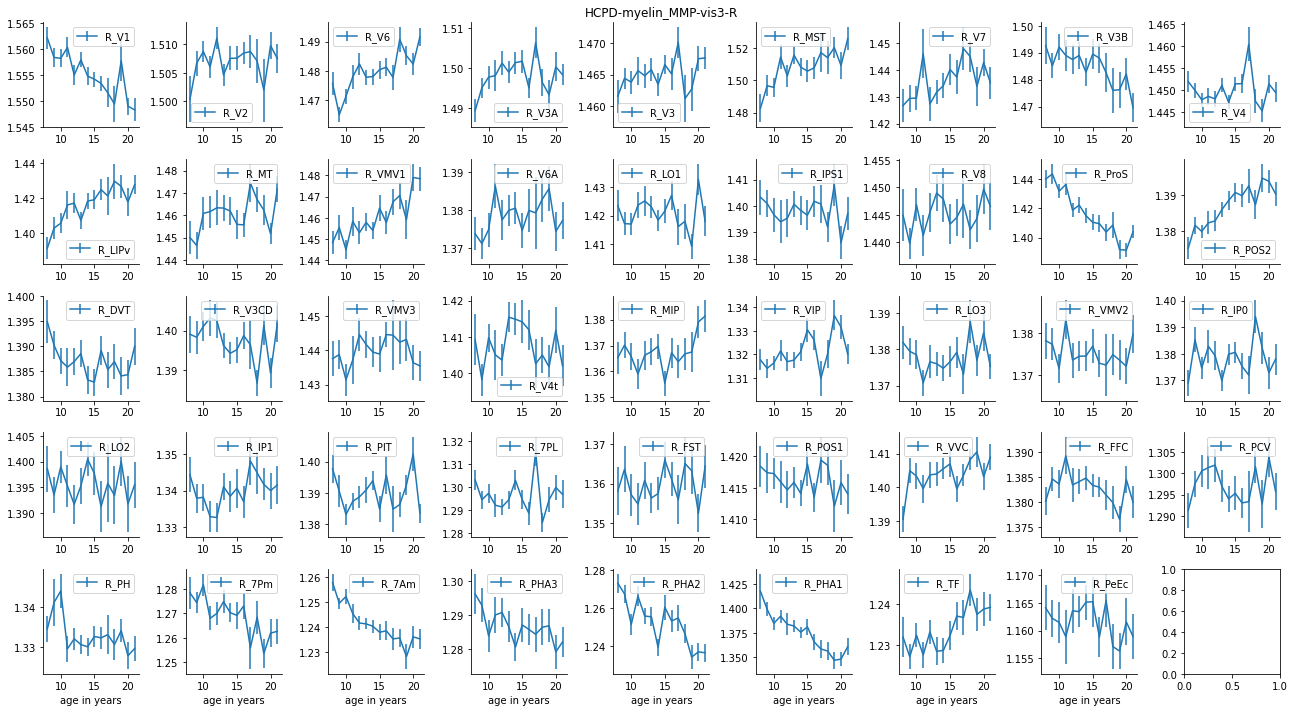

In [22]:
# set parameters
age_mask = 'remove567'
src_file = pjoin(anal_dir, 'ROI_scalar/HCPD-myelin_HCP-MMP.csv')
rois = get_rois('MMP-vis3-R')
arrange_flag = 'M+T-PC1'  # OP-gdist, M+T-PC1
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
n_row, n_col = 5, 9
figsize = (18, 10)
ylim = None
title = 'HCPD-myelin_MMP-vis3-R'
# mode = pjoin(work_dir, f'{title}.jpg')
mode = 'show'

# arrange ROIs
if arrange_flag is None:
    pass
elif arrange_flag == 'OP-gdist':
    # 依据各ROI离枕极的距离从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/gdist_src-OccipitalPole_HCP-MMP.csv'
    ))
    arrange_values = df_tmp.loc[0, rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
elif arrange_flag == 'M+T-PC1':
    # 依据各ROI在HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj PC1中的均值从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_HCP-MMP.csv'
    ), index_col=0)
    arrange_values = df_tmp.loc['C1', rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
else:
    raise ValueError

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True
)
key_groups = [(i,) for i in rois]
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), n_row=n_row, n_col=n_col, x=[ages_uniq]*len(rois),
    figsize=figsize, yerr=prepare_y_bar_line(yerr_dict, key_groups),
    label=key_groups, xlabel=age_name, ylim=ylim, title=title, mode=mode
)

# Plot Age Distribution

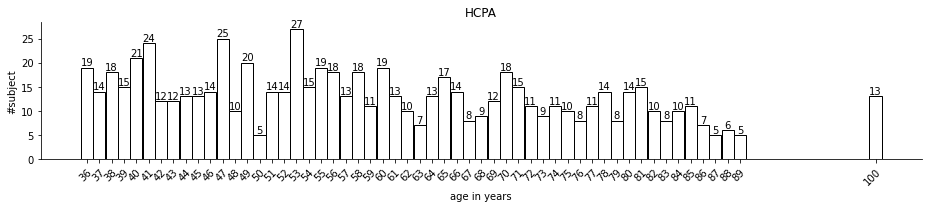

In [9]:
dataset_name = 'HCPA'
# figsize = (6, 3)
figsize = (13, 3)
age_name = 'age in years'
fpath = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
out_file = pjoin(work_dir, f'{dataset_name}_age_dist.jpg')
# out_file = 'show'

df = pd.read_csv(fpath)
ages = np.array(df[age_name])
ages_uniq = np.unique(ages)

y = np.zeros_like(ages_uniq, int)
for idx, age in enumerate(ages_uniq):
    y[idx] = np.sum(ages == age)

plot_bar(y, figsize=figsize, x=ages_uniq, fc_ec_flag=True,
         fc=('w',), ec=('k',), show_height='', xlabel=age_name,
         xticklabel=ages_uniq, rotate_xticklabel=True,
         ylabel='#subject', title=dataset_name, mode=out_file)

# Plot Cluster

## 把detect_community1得到的各map的modularity用bar图展示

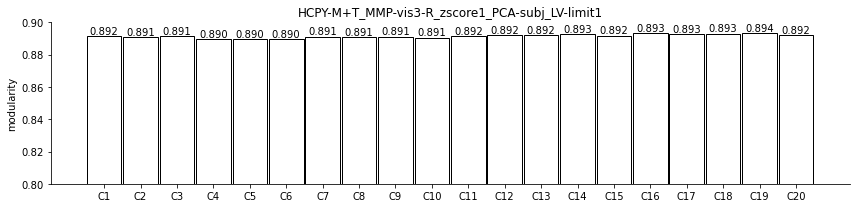

In [3]:
fname = 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1'
df = pd.read_csv(pjoin(anal_dir, f'cluster/{fname}.csv'))
plot_bar(np.array(df['modularity']), figsize=(12, 3) ,fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='.3f', xticklabel=tuple(df['name']), ylabel='modularity', ylim=(0.8, 0.9),
         title=fname, mode=pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1.jpg'))

# Plot Decomposition

## 可视化PCA各成分的解释方差

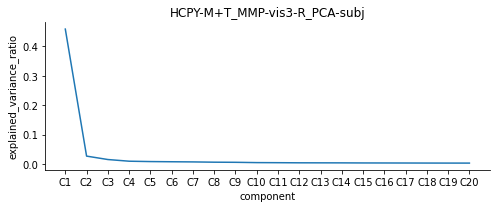

In [2]:
# settings
fname = 'HCPY-M+T_MMP-vis3-R_PCA-subj'
components = 'all'
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

# start
data = pkl.load(open(pjoin(anal_dir, f'decomposition/{fname}.pkl'), 'rb'))
if components == 'all':
    components = np.arange(data.n_components) + 1
else:
    components = np.array(components)
plot_line(
    y=data.explained_variance_ratio_[components - 1], n_row=1, n_col=1, figsize=(7, 3),
    yerr=None, x=None, label=None, color=None, mode=out_file, xlabel='component',
    xtick=None, xticklabel=tuple(f'C{i}' for i in components), rotate_xticklabel=False,
    ylabel='explained_variance_ratio', ylim=None, title=fname
)

## 把多个模态同一个成分的权重时间序列画到只有单个ax的fig里（线图）

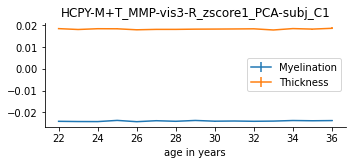

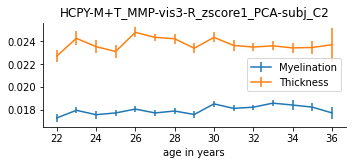

In [10]:
# settings
zscore_flag = False
fnames = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv'
]
labels = ('Myelination', 'Thickness')
cols = ['C1', 'C2']
key_groups_list = [[['0-C1', '1-C1']], [['0-C2', '1-C2']]]
titles = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C1',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C2'
]
out_files = [
    pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C1.jpg'),
    pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C2.jpg')
]
# out_files = ['show', 'show']

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPY'])[age_name]
ages_uniq = np.unique(ages).tolist()
ages_uniq.remove(37)
ages_uniq = np.array(ages_uniq)

# start
data = []
row_names = []
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    data.append(np.array(df[cols]).T)
    row_names.extend([f'{f_idx}-{col}' for col in cols])
data = np.concatenate(data, 0)
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=row_names, zscore_flag=zscore_flag, out_dict=True
)
for i, key_groups in enumerate(key_groups_list):
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
    plot_line(y, n_row=1, n_col=1, figsize=(5, 2.4), yerr=yerr, x=ages_uniq,
              label=labels, color=None, mode=out_files[i], xlabel=age_name, xtick=None,
              xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=titles[i])

## 把同一个成分多个模态的权重平均大小画到只有单个ax的fig里（bar图）

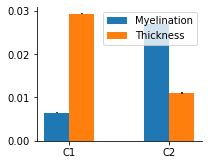

In [5]:
# settings
fnames = [
    'HCPY-M+T_MMP-vis3-R_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_PCA-subj_T.csv'
]
meas = ('Myelination', 'Thickness')
cols = ('C1', 'C2')
# ylim = (0.015, 0.03)
ylim = None
out_file = pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_PCA-subj.jpg')
# out_file = 'show'

# start
n_fname = len(fnames)
n_col = len(cols)
y = np.zeros((n_fname, n_col), np.float64)
yerr = np.zeros((n_fname, n_col), np.float64)
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.mean(samples)
        yerr[f_idx, col_idx] = sem(samples)
plot_bar(
    y, n_row=1, n_col=1, figsize=(3, 2.4), yerr=yerr, x=None, width=None,
    label=meas, color=None, show_height=None, mode=out_file, xlabel=None,
    xticklabel=cols, rotate_xticklabel=False, ylabel=None, ylim=ylim, title=None
)

## 把单个文件中的不同column画到不同ax里

In [3]:
# settings
fname = 'HCPY-M+T_MMP-vis2-LR_zscore0_PCA-vtx'
fpath = pjoin(anal_dir, f'decomposition/{fname}.csv')
cols = ['C1', 'C2', 'C3', 'C4']
out_file = pjoin(work_dir, f'{fname}_37.jpg')
# out_files = 'show'

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPY'])[age_name]
ages_uniq = np.unique(ages).tolist()
# ages_uniq.remove(37)
ages_uniq = np.array(ages_uniq)

# start
n_col = len(cols)
df = pd.read_csv(fpath)
data = np.array(df[cols]).T
y, yerr = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=None, zscore_flag=False, out_dict=False
)
key_groups = [[i] for i in range(n_col)]
y = prepare_y_bar_line(y, key_groups)
yerr = prepare_y_bar_line(yerr, key_groups)
plot_line(y, n_row=2, n_col=2, figsize=(5, 5), yerr=yerr, x=[ages_uniq]*n_col,
          label=None, color=None, mode=out_file, xlabel=age_name, xtick=None,
          xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=cols)

NameError: name 'anal_dir' is not defined

# Plot Fit

## HCPD-M+T=C1C2.csv

### 现有的column

Warning! The sample size of value-5 is 2.
Warning! The sample size of value-6 is 6.


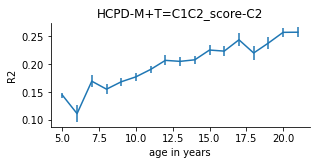

In [13]:
# load data
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)

# prepare plot contents
# cols = ['coef_C2_Myelination', 'coef_C2_Thickness']
# labels = ('Myelination', 'Thickness')
# ylabel='coefficient'
# title = f'{fname}_coef-C2'

cols = ['score_C2']
labels = None
ylabel='R2'
title = f'{fname}_score-C2'

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = False
key_groups = [cols]

# get valid subjects
# outlier_vec1 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-myelin_MMP-vis3-R_RSM-IQR3.npy'))
# outlier_vec2 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-thickness_MMP-vis3-R_RSM-IQR3.npy'))
# non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
# data = data[:, non_outlier_vec]
# ages = ages[non_outlier_vec]
# ages_uniq = np.unique(ages)

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, zscore_flag=zscore_flag, out_dict=True
)
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), figsize=figsize,
    yerr=prepare_y_bar_line(yerr_dict, key_groups), x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel
)


### (|M|-|T|)/(|M|+|T|)

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


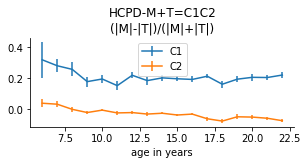

In [9]:
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

figsize = (4.5, 2.4)
labels = ('C1', 'C2')
data = np.zeros((len(labels), df.shape[0]), np.float64)
for lbl_idx, lbl in enumerate(labels):
    m = np.abs(df[f'coef_{lbl}_Myelination'])
    t = np.abs(df[f'coef_{lbl}_Thickness'])
    data[lbl_idx, :] =  (m - t) / (m + t)
title = f'{fname}\n(|M|-|T|)/(|M|+|T|)'
out_file = pjoin(work_dir, f'{fname}_MT-diff.jpg')
# out_file = 'show'

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq,
    label=labels, xlabel=age_name, title=title, mode=out_file
)


### |M|-|T|

Warning! The sample size of value-6 is 4.
Warning! The sample size of value-7 is 5.


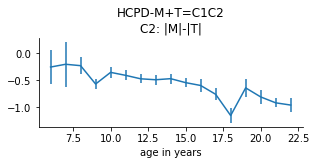

In [12]:
# load data
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

# prepare plot contents
figsize = (4.5, 2.4)
lbl = 'C2'
data = np.zeros((1, df.shape[0]), np.float64)
m = np.abs(df[f'coef_{lbl}_Myelination'])
t = np.abs(df[f'coef_{lbl}_Thickness'])
data[0, :] =  m - t
title = f'{fname}\n{lbl}: |M|-|T|'
out_file = pjoin(work_dir, f'{fname}_MT-diff-{lbl}.jpg')
# out_file = 'show'

# get valid subjects
outlier_vec1 = np.load(pjoin(anal_dir, 'outlier/HCPD-myelin_MMP-vis3-R_RSM-IQR3.npy'))
outlier_vec2 = np.load(pjoin(anal_dir, 'outlier/HCPD-thickness_MMP-vis3-R_RSM-IQR3.npy'))
non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
data = data[:, non_outlier_vec]
ages = ages[non_outlier_vec]
ages_uniq = np.unique(ages)

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, xlabel=age_name,
    title=title, mode=out_file
)

## CalcS+OcPole+MT=C1.csv

score: 0.6942280684268545


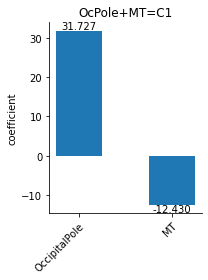

In [8]:
# fname = 'CalcS+OcPole+MT=C1'
# fname = 'CalcS+MT=C1'
fname = 'OcPole+MT=C1'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df['score_C1'].item())
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith('coef_C1_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=out_file)